# UK UBI Analysis

This notebook presents interactive figures from the UBI Center's UK basic income analysis.

All metrics are at the person-level unless otherwise stated.


## Overall


### Changes to government expenditure

All reforms have a budget surplus - each woud generate revenue for the government by raising taxes and removing benefit programs. The surplus for each reform is slightly different due to rounding amounts to the nearest £1/week.

In [72]:
import os

import microdf as mdf
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import ubicenter
from openfisca_uk import IndividualSim, PopulationSim
from openfisca_uk.reforms.modelling import reported_benefits
from plotly import graph_objects as go

%config Completer.use_jedi = False

# Scripts must be run from root directory.
if "py" not in os.listdir("."):
    os.chdir("..")

from py.make_dfs import get_dfs

# Charts and formatting.

LIGHT_BLUE = "#BBDEFB"  # Blue 100.
BLUE = "#1976D2"  # Blue 700.
DARK_BLUE = "#0D47A1"  # Blue 900.
RED = "#FF7043"  # Red 400.
DARK_RED = "#BF360C"  # Red 900.
GRAY = "#BDBDBD"  # Gray 400.

LABELS = {
    "equiv_household_net_income_base_decile": "Income decile",
    "pc": "Net income change",
    "chg_pp": "Net income change",
    "reform": "Reform",
    "gini_pc": "Gini index",
    "top_10_pct_share_pc": "Income share held by top 10%",
    "top_1_pct_share_pc": "Income share held by top 1%",
    "variable": "Variable",
    "value": "Value",
    "in_poverty_bhc_base": "Poverty",
    "in_deep_poverty_bhc_base": "Deep poverty",
    "pov_chg": "Poverty",
    "deep_pov_chg": "Deep poverty",
    "age_group": "Age",
}


def ubi_chart(fig, name):
    fig = ubicenter.format_fig(fig, show=False)
    fig.write_image(f"images/{name}.png", scale=2)
    ubicenter.format_fig(fig)


optimal_params = pd.read_csv("optimal_params.csv")


# h = get_dfs()
p, h, reform, decile = get_dfs()
# p, h, reform = get_dfs()


color_map = {
    reform.index[0]: LIGHT_BLUE,
    reform.index[1]: BLUE,
    reform.index[2]: DARK_BLUE,
}

pov_color_map = {
    "Poverty": RED,
    "Deep poverty": DARK_RED,
}

## Reform comparisons


### UBI Specifications

The UBI reforms give the following amounts per week:

In [2]:
REGION_NAMES = [
    "North East",
    "North West",
    "Yorkshire and the Humber",
    "East Midlands",
    "West Midlands",
    "East of England",
    "London",
    "South East",
    "South West",
    "Wales",
    "Scotland",
    "Northern Ireland",
]
optimal_params_print = optimal_params.T.drop("mean_pct_loss")
optimal_params_print.index = ["Senior", "Adult", "Child", "Disability"] + REGION_NAMES
optimal_params_print.columns = reform.index
# Otherwise shows "reform" in upper left.
optimal_params_print.columns.name = ""
optimal_params_print.applymap(lambda x: "£" + str(int(x)))

1: Foundational 2: Disability 3: Disability + geo
Senior                              £123          £119                £114
Adult                               £205          £196                £191
Child                                £75           £76                 £70
Disability                            £0           £68                 £69
North East                            £0            £0                  £7
North West                            £0            £0                  £6
Yorkshire and the Humber              £0            £0                  £0
East Midlands                         £0            £0                  £4
West Midlands                         £0            £0                  £4
East of England                       £0            £0                  £3
London                                £0            £0                  £7
South East                            £0            £0                  £4
South West                            £0            £0                  £5
Wales                                 £0            £0                  £3
Scotland                              £0            £0                  £5
Northern Ireland                      £0            £0                  £3

### Disruption

The mean percent loss is the mean income loss as a percentage of net income among those who lose income from the reform.

NB: This is higher than what's in the optimization notebook, due to rounding UBI amounts.

In [3]:
disruption = reform[["household_net_income_pl", "winner"]] * 100
disruption.columns = ["Mean percentage loss", "Population share coming out ahead"]
disruption.style.format("{:,.1f}%".format)

### Inequality

Each reform reduces inequality substantially, especially the Gini index and when providing a disability supplement.

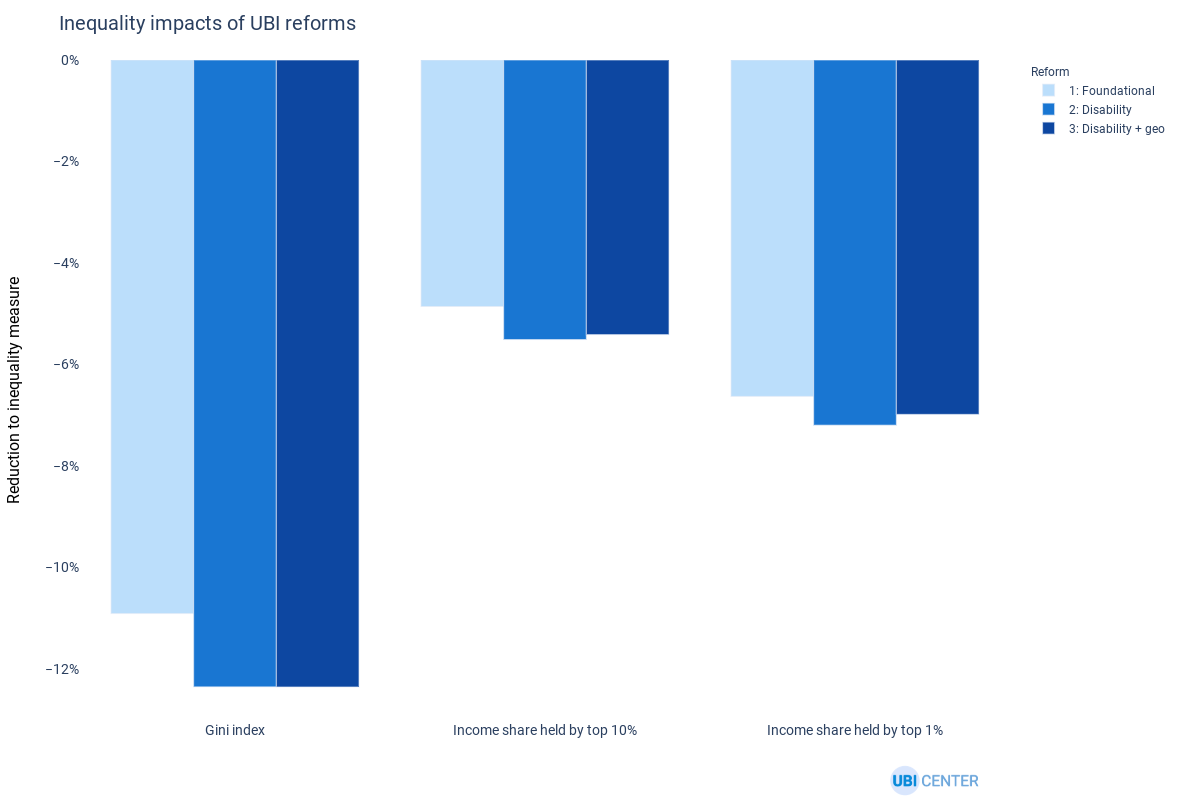

In [4]:
reform["reform"] = reform.index
ineq = reform[["reform", "gini_pc", "top_10_pct_share_pc", "top_1_pct_share_pc"]].melt(id_vars="reform")
ineq.variable = ineq.variable.map(LABELS)

fig = px.bar(ineq, "variable", "value", color="reform", labels=LABELS, color_discrete_map=color_map)
fig.update_layout(
    title="Inequality impacts of UBI reforms",
    xaxis_title="",
    yaxis_title="Reduction to inequality measure",
    yaxis_tickformat=".0%",
    barmode='group',
)
ubi_chart(fig, "inequality")

### Changes to poverty by reform

Poverty rate, deep poverty rate, poverty gap, poverty severity.

### Changes by income decile

The following graph shows the percentage change to aggregate equivalised household net income for each decile per reform.

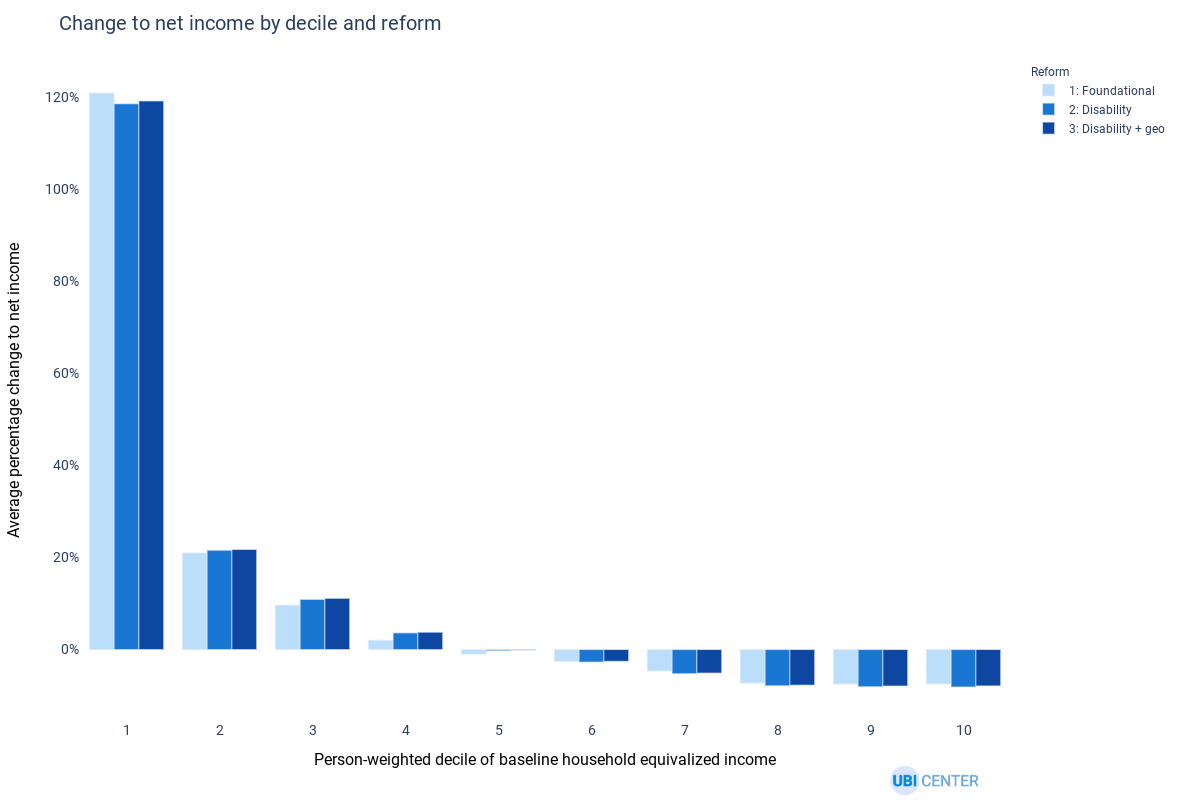

In [18]:
fig = px.bar(
    decile,
    "decile",
    "pc",
    color="reform",
    barmode="group",
    labels=LABELS,
    color_discrete_map=color_map
)
fig.update_layout(
    title="Change to net income by decile and reform",
    xaxis_title="Person-weighted decile of baseline household equivalized income",
    yaxis_title="Average percentage change to net income",
    yaxis_tickformat="%",
    xaxis_dtick=1
)
ubi_chart(fig, "decile")

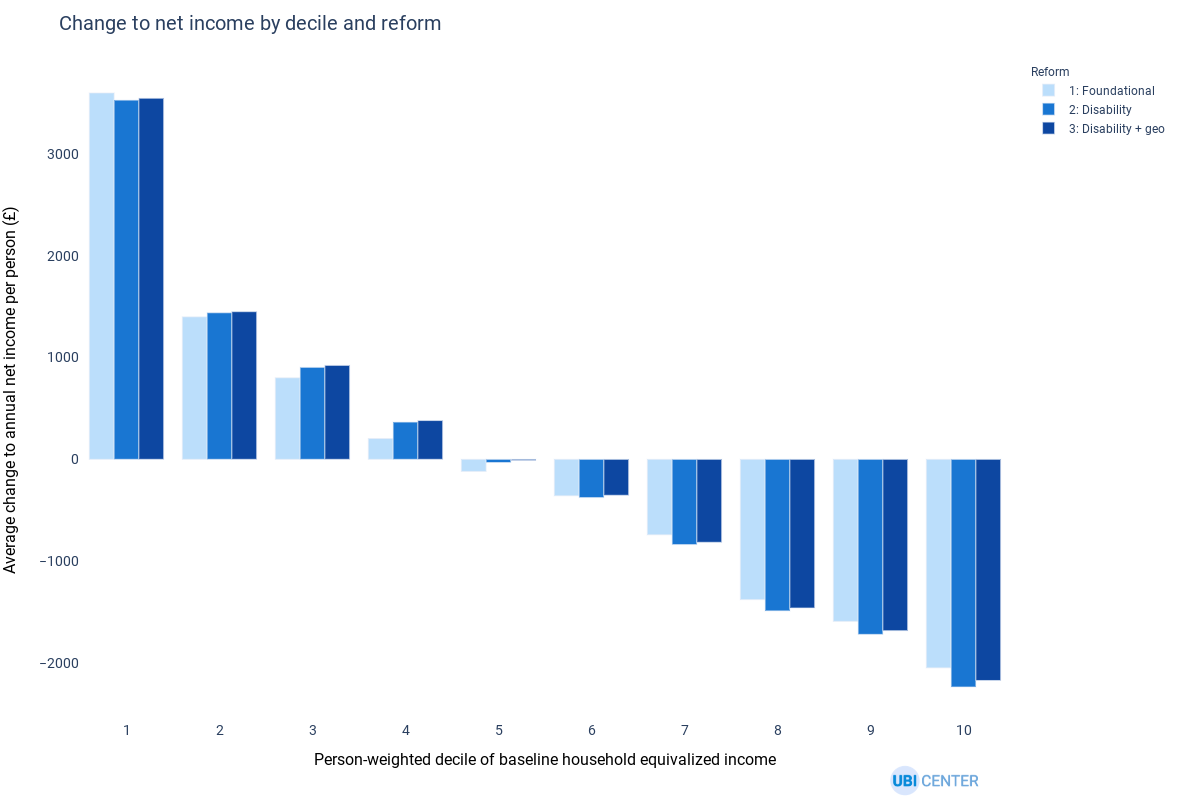

In [17]:
# Should this be weekly?
fig = px.bar(
    decile,
    "decile",
    "chg_pp",
    color="reform",
    barmode="group",
    labels=LABELS,
    color_discrete_map=color_map,
)
fig.update_layout(
    title="Change to net income by decile and reform",
    xaxis_title="Person-weighted decile of baseline household equivalized income",
    yaxis_title="Average change to annual net income per person (£)",
    xaxis_dtick=1,
)
ubi_chart(fig, "decile")

This should be closer to zero after re-running the optimization.

In [19]:
decile.groupby("reform").chg_pp.sum()

reform
1: Foundational       -235.691647
2: Disability         -453.367018
3: Disability + geo   -196.753177
dtype: float64

### Poverty changes

In [79]:
p["age_group"] = np.where(p.age < 18, "0 to 17", np.where(p.age < 65, "18 to 64", "65 and older"))

In [80]:
p.columns

Index(['household_weight', 'age', 'region', 'is_disabled_for_ubi',
       'household_net_income_base', 'in_poverty_bhc_base',
       'in_deep_poverty_bhc_base', 'household_net_income', 'in_poverty_bhc',
       'in_deep_poverty_bhc', 'reform', 'region_name',
       'household_net_income_chg', 'household_net_income_pc',
       'household_net_income_pl', 'winner', '__tmp_weights', 'age_group'],
      dtype='object')

In [81]:
POVS = ["in_poverty_bhc", "in_deep_poverty_bhc"]
POV_COLS = ["in_poverty_bhc", "in_poverty_bhc_base", "in_deep_poverty_bhc", "in_deep_poverty_bhc_base"]
GROUPS = ["reform", "age_group"]
pov = (p[GROUPS + POV_COLS].groupby(GROUPS).mean() / 52).reset_index()

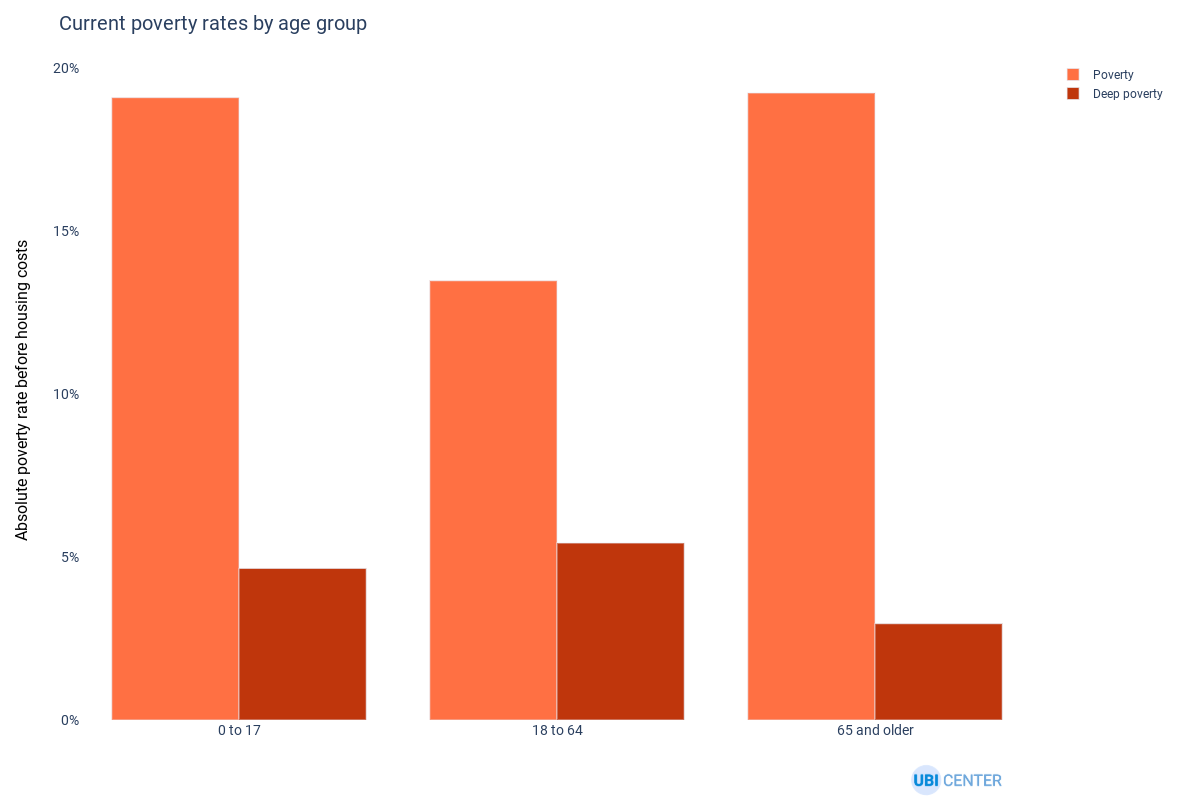

In [82]:
cur_pov = pov[pov.reform == "1: Foundational"][
    ["age_group", "in_poverty_bhc_base", "in_deep_poverty_bhc_base"]
]
cur_pov_long = cur_pov.melt(id_vars="age_group")
cur_pov_long.variable = cur_pov_long.variable.map(LABELS)
fig = px.bar(
    cur_pov_long,
    "age_group",
    "value",
    color="variable",
    barmode="group",
    color_discrete_map=pov_color_map,
    labels=LABELS,
)
fig.update_layout(
    title="Current poverty rates by age group",
    xaxis_title="",
    legend_title="",
    yaxis_title="Absolute poverty rate before housing costs",
    yaxis_tickformat="%",
)
ubi_chart(fig, "current_poverty")

In [84]:
pov["pov_chg"] = pov.in_poverty_bhc / pov.in_poverty_bhc_base - 1
pov["deep_pov_chg"] = pov.in_deep_poverty_bhc / pov.in_deep_poverty_bhc_base - 1
pov_chg_long = pov.melt(["reform", "age_group"], ["pov_chg", "deep_pov_chg"])
pov_chg_long.variable = pov_chg_long.variable.map(LABELS)

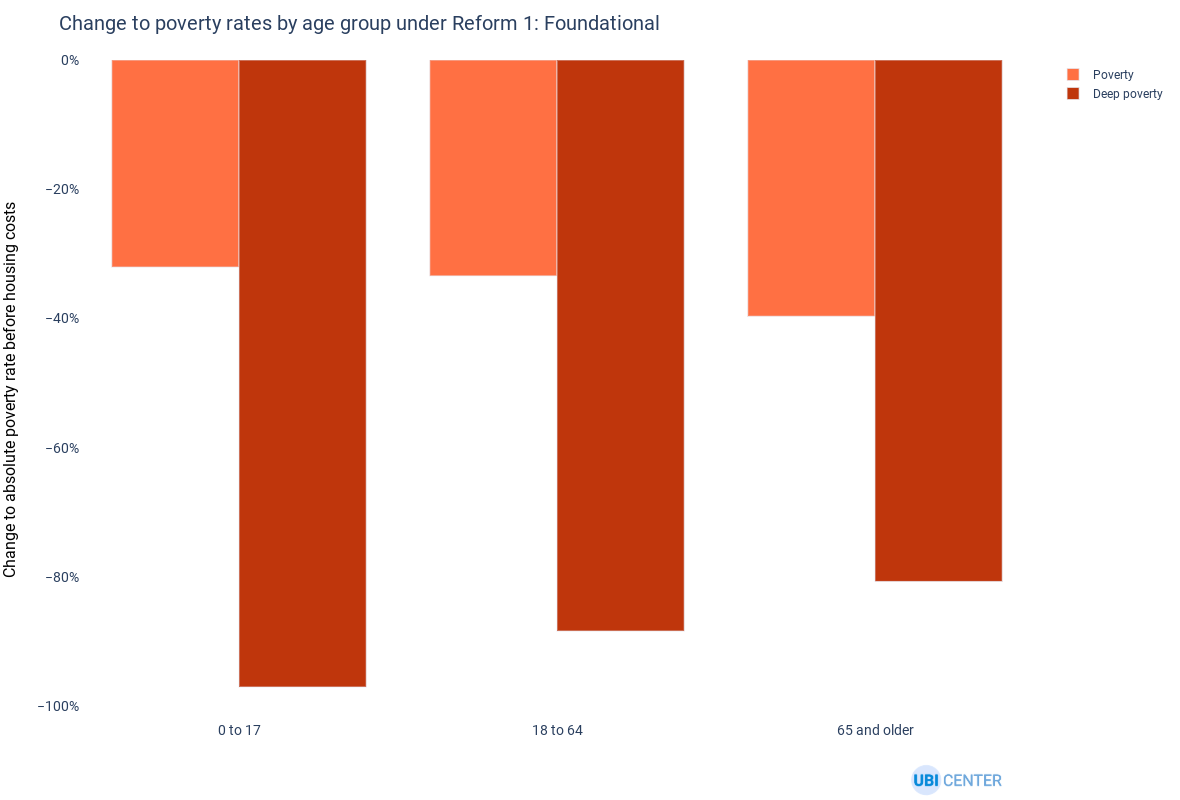

In [87]:
fig = px.bar(
    pov_chg_long[pov_chg_long.reform == "1: Foundational"],
    "age_group",
    "value",
    color="variable",
    barmode="group",
    color_discrete_map=pov_color_map,
    labels=LABELS,
)
fig.update_layout(
    title="Change to poverty rates by age group under Reform 1: Foundational",
    xaxis_title="",
    legend_title="",
    yaxis_title="Change to absolute poverty rate before housing costs",
    yaxis_tickformat="%",
)
ubi_chart(fig, "poverty_change_1")

In [88]:
reform

household_net_income_pl    winner  gini_base  \
reform                                                              
1: Foundational                    -0.058082  0.540534   0.384585   
2: Disability                      -0.054601  0.533386   0.384585   
3: Disability + geo                -0.054040  0.536450   0.384585   

                     top_10_pct_share_base  top_1_pct_share_base  gini_reform  \
reform                                                                          
1: Foundational                   0.282531              0.053363     0.342621   
2: Disability                     0.282531              0.053363     0.337066   
3: Disability + geo               0.282531              0.053363     0.337056   

                     top_10_pct_share_reform  top_1_pct_share_reform  \
reform                                                                 
1: Foundational                     0.268803                0.049825   
2: Disability                       0.266963                0.049522   
3: Disability + geo                 0.267238                0.049636   

                                  reform   gini_pc  top_10_pct_share_pc  \
reform                                                                    
1: Foundational          1: Foundational -0.109115            -0.048590   
2: Disability              2: Disability -0.123559            -0.055102   
3: Disability + geo  3: Disability + geo -0.123585            -0.054131   

                     top_1_pct_share_pc  
reform                                   
1: Foundational               -0.066307  
2: Disability                 -0.071973  
3: Disability + geo           -0.069847

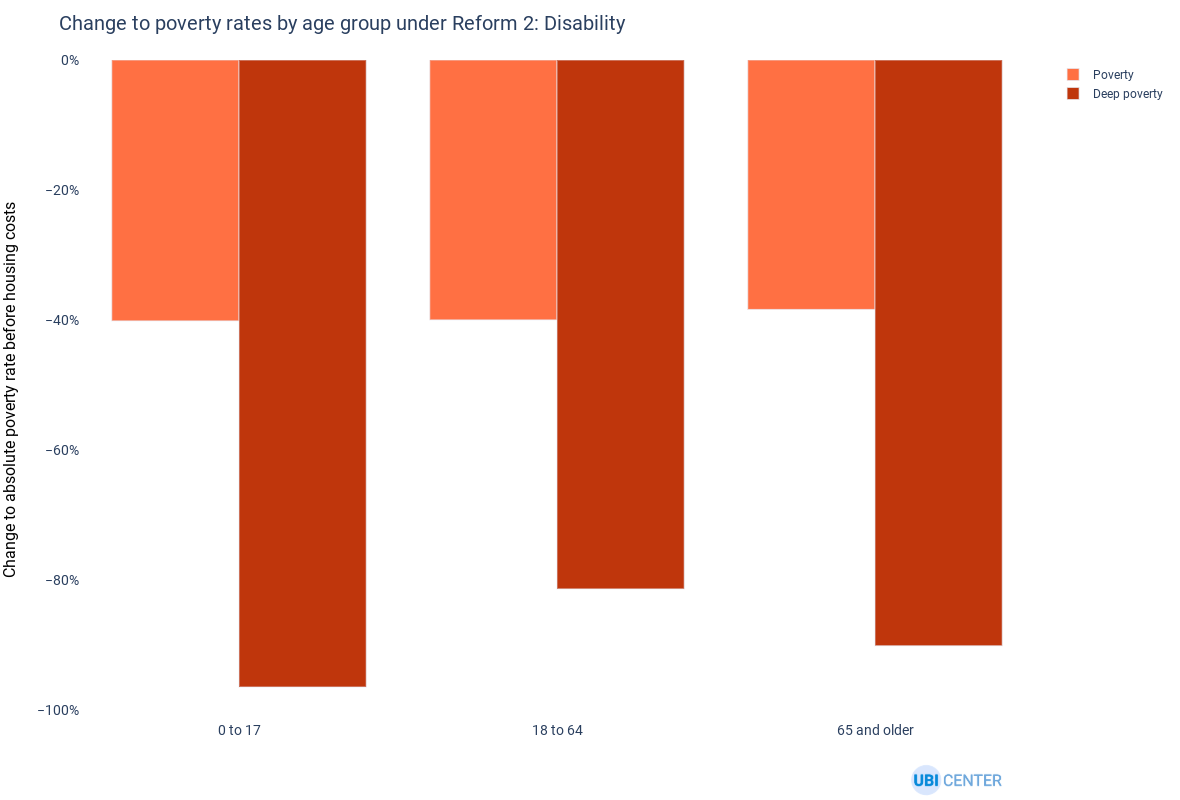

In [86]:
fig = px.bar(
    pov_chg_long[pov_chg_long.reform == "2: Disability"],
    "age_group",
    "value",
    color="variable",
    barmode="group",
    color_discrete_map=pov_color_map,
    labels=LABELS,
)
fig.update_layout(
    title="Change to poverty rates by age group under Reform 2: Disability",
    xaxis_title="",
    legend_title="",
    yaxis_title="Change to absolute poverty rate before housing costs",
    yaxis_tickformat="%",
)
ubi_chart(fig, "poverty_change_2")

## Reform details

This section contains a more in-depth inspection of the changes to individuals under Reform 2, which is a suitable representative of the shared aspects of the three reforms.

### Intra-decile changes

We have that the changes to income are broadly progressive along the income deciles, however there is significant diversity of outcomes within each decile due to differing compositions of income, family and individual characteristics such as disability. The following chart shows the distribution of outcomes within each income decile.

In [ ]:
#@title
import seaborn as sns
import matplotlib
N = 4
COLORS = list(map(lambda rgba_color : matplotlib.colors.to_hex(rgba_color), sns.diverging_palette(220, 20, as_cmap=True)(np.linspace(0, 1, num=N))))[::-1]
MIN_PCT_CHANGE = -0.05
MAX_PCT_CHANGE = 0.05
pivot = int(MAX_PCT_CHANGE * 100)
change_bin_names = [f"Lose more than {pivot}%", f"Lose less than {pivot}%", f"Gain less than {pivot}%", f"Gain more than {pivot}%"]

interval_size = (MAX_PCT_CHANGE - MIN_PCT_CHANGE) / (N - 2)
change_bin_bands = pd.IntervalIndex.from_tuples([(-np.inf, MIN_PCT_CHANGE)] + [(MIN_PCT_CHANGE + i * interval_size, MIN_PCT_CHANGE + (i + 1) * interval_size) for i in range(N - 2)] + [(MAX_PCT_CHANGE, np.inf)])
# change_bin_names = np.array([f"<{MIN_PCT_CHANGE * 100}%"] + [f"{round((MIN_PCT_CHANGE + i * interval_size) * 100)}%" for i in range(N - 2)] + [f">{MAX_PCT_CHANGE * 100}%"])


COLORS = COLORS[::-1]
change_bin_bands = change_bin_bands[::-1]
change_bin_names = change_bin_names[::-1]

reform_sim = reform_sims[1]
reform_name = reform_names[1]
df = pd.DataFrame()
df["household_weight"] = baseline_sim.calc("household_weight", map_to="person")
df["household_net_income"] = np.maximum(0, baseline_sim.calc("equiv_household_net_income", map_to="person"))
#change_bin_names = [f"Decrease more than {interval}%", f"Decrease less than {interval}%", f"Gain less than {interval}%", f"Gain more than {interval}%"]
#change_bin_bands = pd.IntervalIndex.from_tuples([(-np.inf, - interval / 100), (- interval / 100, 0), (0, interval / 100), (interval / 100, np.inf)])

decile_names = list(map(str, range(1, 11))) + ["All"]
'''
COLORS = [
    "#004ba0",  # Dark blue.
    "#63a4ff",  # Light blue.
    "#ffc046",  # Light amber.
    "#c56000",  # Medium amber.
]
'''

df["income_abs_change"] = np.maximum(0, reform_sim.calc("equiv_household_net_income", map_to="person")) - df["household_net_income"]
df["income_rel_change"] = df["income_abs_change"] / df["household_net_income"]
df["income_rel_change_band"] = pd.cut(df["income_rel_change"], change_bin_bands)
df["is_disabled_for_ubi"] = baseline_sim.calc("is_disabled_for_ubi") > 0
#df["is_sev_disabled_for_ubi"] = baseline_sim.calc("is_severely_disabled_for_ubi") > 0
#df["is_enh_disabled_for_ubi"] = baseline_sim.calc("is_enhanced_disabled_for_ubi") > 0
df["lone_parent"] = baseline_sim.calc("is_lone_parent", map_to="person") > 0
df["lone_senior"] = baseline_sim.calc("is_single_person", map_to="person") * baseline_sim.calc("is_SP_age") > 0
df["poverty"] = baseline_sim.calc("in_poverty_bhc", map_to="person") > 0
mdf.add_weighted_quantiles(df, "household_net_income", "household_weight")

def get_distr(df, condition=None):
  if condition is not None:
    filtered_df = df[condition]
  else:
    filtered_df = df
  grouped_by_outcome = filtered_df.groupby("income_rel_change_band").sum()["household_weight"]
  return grouped_by_outcome / grouped_by_outcome.sum()

fig = go.Figure()

outcomes = []
for subset in [df["household_net_income_decile"] == i for i in range(1, 11)] + [None]:
  outcomes += [get_distr(df, subset)]

outcome_band_shares = np.array(outcomes).transpose()
for outcome_band, name, i in zip(outcome_band_shares, change_bin_names, range(N)):
  text = [f"{int(percent * 100)}%" for percent in outcome_band]
  fig.add_trace(go.Bar(text=text, textposition="inside", orientation="h", y=decile_names, x=outcome_band, name=name, marker_color=COLORS[i]))

fig.update_traces(marker_line_width=0)
fig.update_layout(barmode="stack", yaxis_title="Decile", xaxis_title="Distribution of outcomes", title=reform_name + " - outcome distribution by decile", yaxis_type="category", xaxis=dict(tickvals=[0.1 * x for x in range(1, 11)], tickformat="%")),
ubi_chart(fig, "intra_decile_continuous")
fig.show()

In [ ]:
#@title
import seaborn as sns
import matplotlib
N = 400
COLORS = list(map(lambda rgba_color : matplotlib.colors.to_hex(rgba_color), sns.diverging_palette(220, 20, as_cmap=True)(np.linspace(0, 1, num=N))))[::-1]
MIN_PCT_CHANGE = -0.25
MAX_PCT_CHANGE = 0.25
interval_size = (MAX_PCT_CHANGE - MIN_PCT_CHANGE) / (N - 2)
change_bin_bands = pd.IntervalIndex.from_tuples([(-np.inf, MIN_PCT_CHANGE)] + [(MIN_PCT_CHANGE + i * interval_size, MIN_PCT_CHANGE + (i + 1) * interval_size) for i in range(N - 2)] + [(MAX_PCT_CHANGE, np.inf)])
change_bin_names = np.array([f"<{MIN_PCT_CHANGE * 100}%"] + [f"{round((MIN_PCT_CHANGE + i * interval_size) * 100)}%" for i in range(N - 2)] + [f">{MAX_PCT_CHANGE * 100}%"])

COLORS = COLORS[::-1]
change_bin_bands = change_bin_bands[::-1]
change_bin_names = change_bin_names[::-1]

reform_sim = reform_sims[1]
reform_name = reform_names[1]
df = pd.DataFrame()
df["household_weight"] = baseline_sim.calc("household_weight", map_to="person")
df["household_net_income"] = np.maximum(0, baseline_sim.calc("equiv_household_net_income", map_to="person"))
#change_bin_names = [f"Decrease more than {interval}%", f"Decrease less than {interval}%", f"Gain less than {interval}%", f"Gain more than {interval}%"]
#change_bin_bands = pd.IntervalIndex.from_tuples([(-np.inf, - interval / 100), (- interval / 100, 0), (0, interval / 100), (interval / 100, np.inf)])

decile_names = list(map(str, range(1, 11))) + ["All"]
'''
COLORS = [
    "#004ba0",  # Dark blue.
    "#63a4ff",  # Light blue.
    "#ffc046",  # Light amber.
    "#c56000",  # Medium amber.
]
'''

df["income_abs_change"] = np.maximum(0, reform_sim.calc("equiv_household_net_income", map_to="person")) - df["household_net_income"]
df["income_rel_change"] = df["income_abs_change"] / df["household_net_income"]
df["income_rel_change_band"] = pd.cut(df["income_rel_change"], change_bin_bands)
df["is_disabled_for_ubi"] = baseline_sim.calc("is_disabled_for_ubi") > 0
df["lone_parent"] = baseline_sim.calc("is_lone_parent", map_to="person") > 0
df["lone_senior"] = baseline_sim.calc("is_single_person", map_to="person") * baseline_sim.calc("is_SP_age") > 0
df["poverty"] = baseline_sim.calc("in_poverty_bhc", map_to="person") > 0
mdf.add_weighted_quantiles(df, "household_net_income", "household_weight")

def get_distr(df, condition=None):
  if condition is not None:
    filtered_df = df[condition]
  else:
    filtered_df = df
  grouped_by_outcome = filtered_df.groupby("income_rel_change_band").sum()["household_weight"]
  return grouped_by_outcome / grouped_by_outcome.sum()

fig = go.Figure()

outcomes = []
for subset in [df["household_net_income_decile"] == i for i in range(1, 11)] + [None]:
  outcomes += [get_distr(df, subset)]

outcome_band_shares = np.array(outcomes).transpose()
for outcome_band, name, i in zip(outcome_band_shares, change_bin_names, range(N)):
  labels = np.array([change_bin_names[i]] * 11)
  fig.add_trace(go.Bar(showlegend = i in [0, len(change_bin_bands) // 2 - 1, len(change_bin_bands) - 1], customdata=labels, orientation="h", y=decile_names, x=outcome_band, name=name, marker_color=COLORS[i], hovertemplate=["Outcome %{customdata}<extra></extra>"]))

fig.update_traces(marker_line_width=0)
fig.update_layout(barmode="stack", yaxis_title="Decile", xaxis_title="Distribution of outcomes", title=reform_name + " - outcome distribution by decile", yaxis_type="category", xaxis=dict(tickvals=[0.1 * x for x in range(1, 11)], tickformat="%")),
ubi_chart(fig, "intra_decile_discrete")
fig.show()

### Intra-group changes

In [ ]:
#@title
import seaborn as sns
import matplotlib
from rdbl import num
N = 4
MIN_PCT_CHANGE = -0.05
MAX_PCT_CHANGE = 0.05
pivot = int(MAX_PCT_CHANGE * 100)
change_bin_names = [f"Lose more than {pivot}%", f"Lose less than {pivot}%", f"Gain less than {pivot}%", f"Gain more than {pivot}%"]

COLORS = list(map(lambda rgba_color : matplotlib.colors.to_hex(rgba_color), sns.diverging_palette(220, 20, as_cmap=True)(np.linspace(0, 1, num=N))))[::-1]

interval_size = (MAX_PCT_CHANGE - MIN_PCT_CHANGE) / (N - 2)
change_bin_bands = pd.IntervalIndex.from_tuples([(-np.inf, MIN_PCT_CHANGE)] + [(MIN_PCT_CHANGE + i * interval_size, MIN_PCT_CHANGE + (i + 1) * interval_size) for i in range(N - 2)] + [(MAX_PCT_CHANGE, np.inf)])

COLORS = COLORS[::-1]
change_bin_bands = change_bin_bands[::-1]
change_bin_names = change_bin_names[::-1]

reform_sim = reform_sims[1]
reform_name = reform_names[1]
df = pd.DataFrame()
df["household_weight"] = baseline_sim.calc("household_weight", map_to="person")
df["household_net_income"] = np.maximum(0, baseline_sim.calc("equiv_household_net_income", map_to="person"))
#change_bin_names = [f"Decrease more than {interval}%", f"Decrease less than {interval}%", f"Gain less than {interval}%", f"Gain more than {interval}%"]
#change_bin_bands = pd.IntervalIndex.from_tuples([(-np.inf, - interval / 100), (- interval / 100, 0), (0, interval / 100), (interval / 100, np.inf)])

decile_names = ["Single, with children", "Single, no children", "Couples, no children", "Couples, with children"]
'''
COLORS = [
    "#004ba0",  # Dark blue.
    "#63a4ff",  # Light blue.
    "#ffc046",  # Light amber.
    "#c56000",  # Medium amber.
]
'''

df["income_abs_change"] = np.maximum(0, reform_sim.calc("equiv_household_net_income", map_to="person")) - df["household_net_income"]
df["income_rel_change"] = df["income_abs_change"] / df["household_net_income"]
df["income_rel_change_band"] = pd.cut(df["income_rel_change"], change_bin_bands)

single = baseline_sim.calc("is_single", map_to="person")
kids = baseline_sim.map_to(baseline_sim.calc("is_child", map_to="benunit"), entity="benunit", target_entity="person")

df["single_no_kids"] = single * (kids == 0)
df["couple_no_kids"] = (1 - single) * (kids == 0)
df["single_kids"] = single * (kids > 0)
df["couple_kids"] = (1 - single) * (kids > 0)

cols = ["single_kids", "single_no_kids", "couple_no_kids", "couple_kids"]
mdf.add_weighted_quantiles(df, "household_net_income", "household_weight")

for i in range(len(decile_names)):
    total_pop = np.sum(df[cols[i]] * df["household_weight"])
    decile_names[i] += f" ({num(total_pop)})"

def get_distr(df, condition=None):
  if condition is not None:
    filtered_df = df[condition]
  else:
    filtered_df = df
  grouped_by_outcome = filtered_df.groupby("income_rel_change_band").sum()["household_weight"]
  return grouped_by_outcome / grouped_by_outcome.sum()

fig = go.Figure()

outcomes = []
for subset in [df[x] > 0 for x in cols]:
  outcomes += [get_distr(df, subset)]

outcome_band_shares = np.array(outcomes).transpose()
for outcome_band, name, i in zip(outcome_band_shares, change_bin_names, range(N)):
  text = [f"{int(percent * 100)}%" for percent in outcome_band]
  fig.add_trace(go.Bar(text=text, textposition="inside", orientation="h", y=decile_names, x=outcome_band, name=name, marker_color=COLORS[i]))

fig.update_traces(marker_line_width=0)
fig.update_layout(xaxis=dict(tickvals=[0.1 * x for x in range(1, 11)], tickformat="%"), hovermode=False, barmode="stack", yaxis_title="Family composition", xaxis_title="Distribution of outcomes", title=reform_name + " - outcome distribution by family composition", yaxis_type="category"),
ubi_chart(fig, "intra_family_type")
fig.show()

In [ ]:
#@title
import seaborn as sns
import matplotlib
N = 4
MIN_PCT_CHANGE = -0.05
MAX_PCT_CHANGE = 0.05
pivot = int(MAX_PCT_CHANGE * 100)
change_bin_names = [f"Lose more than {pivot}%", f"Lose less than {pivot}%", f"Gain less than {pivot}%", f"Gain more than {pivot}%"]

COLORS = list(map(lambda rgba_color : matplotlib.colors.to_hex(rgba_color), sns.diverging_palette(220, 20, as_cmap=True)(np.linspace(0, 1, num=N))))[::-1]

interval_size = (MAX_PCT_CHANGE - MIN_PCT_CHANGE) / (N - 2)
change_bin_bands = pd.IntervalIndex.from_tuples([(-np.inf, MIN_PCT_CHANGE)] + [(MIN_PCT_CHANGE + i * interval_size, MIN_PCT_CHANGE + (i + 1) * interval_size) for i in range(N - 2)] + [(MAX_PCT_CHANGE, np.inf)])

COLORS = COLORS[::-1]
change_bin_bands = change_bin_bands[::-1]
change_bin_names = change_bin_names[::-1]

reform_sim = reform_sims[1]
reform_name = reform_names[1]
df = pd.DataFrame()
df["household_weight"] = baseline_sim.calc("household_weight", map_to="person")
df["household_net_income"] = np.maximum(0, baseline_sim.calc("equiv_household_net_income", map_to="person"))
#change_bin_names = [f"Decrease more than {interval}%", f"Decrease less than {interval}%", f"Gain less than {interval}%", f"Gain more than {interval}%"]
#change_bin_bands = pd.IntervalIndex.from_tuples([(-np.inf, - interval / 100), (- interval / 100, 0), (0, interval / 100), (interval / 100, np.inf)])

ages = [10, 20, 30, 40, 50, 60, 70, 80, 120]

decile_names = ["Under 10"] + [str(ages[i]) + " - " + str(ages[i + 1]-1) for i in range(7)] + ["80 or over"]
'''
COLORS = [
    "#004ba0",  # Dark blue.
    "#63a4ff",  # Light blue.
    "#ffc046",  # Light amber.
    "#c56000",  # Medium amber.
]
'''

df["income_abs_change"] = np.maximum(0, reform_sim.calc("equiv_household_net_income", map_to="person")) - df["household_net_income"]
df["income_rel_change"] = df["income_abs_change"] / df["household_net_income"]
df["income_rel_change_band"] = pd.cut(df["income_rel_change"], change_bin_bands)

age = baseline_sim.calc("age")

df["min"] = age < 10
df["max"] = age > 79

names = ["min"]

for i in range(len(ages) - 1):
    names += [f"{ages[i]}"]
    df[f"{ages[i]}"] = (age >= ages[i]) * (age < ages[i + 1])
mdf.add_weighted_quantiles(df, "household_net_income", "household_weight")

names += ["max"]


for i in range(len(decile_names)):
    total_pop = np.sum(df[names[i]] * df["household_weight"])
    decile_names[i] += f" ({num(total_pop)})"

def get_distr(df, condition=None):
  if condition is not None:
    filtered_df = df[condition]
  else:
    filtered_df = df
  grouped_by_outcome = filtered_df.groupby("income_rel_change_band").sum()["household_weight"]
  return grouped_by_outcome / grouped_by_outcome.sum()

fig = go.Figure()

outcomes = []
for subset in [df[x] > 0 for x in names]:
  outcomes += [get_distr(df, subset)]

outcome_band_shares = np.array(outcomes).transpose()
for outcome_band, name, i in zip(outcome_band_shares, change_bin_names, range(N)):
  text = [f"{int(percent * 100)}%" for percent in outcome_band]
  fig.add_trace(go.Bar(text=text, textposition="inside", orientation="h", y=decile_names, x=outcome_band, name=name, marker_color=COLORS[i]))

fig.update_traces(marker_line_width=0)
fig.update_layout(xaxis=dict(tickvals=[0.1 * x for x in range(1, 11)], tickformat="%"), hovermode=False, barmode="stack", yaxis_title="Age group", xaxis_title="Distribution of outcomes", title=reform_name + " - outcome distribution by age", yaxis_type="category"),
ubi_chart(fig, "intra_age")
fig.show()

### Poverty changes by group

Below we show the changes to two metrics of poverty. We define poverty in line with official UK statistics, as whether the equivalised household (before housing costs) income of a person falls below a threshold (£253 per week in this case). This gives us the metrics of the poverty rate, which is the number of individuals whose household fulfils this requirement, and the poverty gap, which is minimum spending necessary to eliminate poverty.

In [ ]:
# @title
from rdbl import gbp


def poverty_gap(sim, weight):
    return np.sum(
        sim.calc("poverty_gap_bhc", map_to="household")
        * sim.calc("household_weight", map_to="household")
        * weight
    )


def poverty_rate(sim, weight):
    return np.average(
        sim.calc("in_poverty_bhc", map_to="person") > 0,
        weights=sim.calc("household_weight", map_to="person") * weight,
    )

person, household, benunit = baseline_sim.model.populations.values()

weights = [
    None,
    "is_WA_adult",
    "is_child",
    "is_SP_age",
    "tax_credits",
    "is_disabled_for_ubi",
    "is_lone_parent",
]

fig = go.Figure()

group_names = [
    "All",
    "Working-age adults",
    "Children",
    "Pension-age adults",
    "People receiving Tax Credits",
    "Disabled",
    "Lone parent families",
]
for reform_sim, reform_name in zip(reform_sims, reform_names):
    poverty_gap_reductions = []
    poverty_rate_reductions = []
    for weight in weights:
        if weight == "tax_credits":
            weight_arr = (
                household.sum(baseline_sim.calc("working_tax_credit", map_to="person"))
                + household.sum(baseline_sim.calc("child_tax_credit", map_to="person"))
                > 0
            )
            weight_arr_p = (
                baseline_sim.calc(
                    "working_tax_credit_reported", map_to="person"
                )
                + baseline_sim.calc(
                    "child_tax_credit_reported", map_to="person"
                )
                > 0
            )
        elif weight == "is_lone_parent":
            weight_arr = (
                household.sum(baseline_sim.calc("is_lone_parent", map_to="person")) / household.nb_persons()
                > 0
            )
            weight_arr_p = (
                baseline_sim.calc(
                    "is_lone_parent", map_to="person"
                )
                > 0
            )
            
        elif weight is None:
            weight_arr = True
            weight_arr_p = True
        else:
            weight_arr = baseline_sim.calc(weight, map_to="household") > 0
            weight_arr_p = baseline_sim.calc(weight, map_to="person") > 0
        baseline_gap = poverty_gap(baseline_sim, weight_arr)
        reformed_gap = poverty_gap(reform_sim, weight_arr)
        baseline_rate = poverty_rate(baseline_sim, weight_arr_p)
        reformed_rate = poverty_rate(reform_sim, weight_arr_p)
        # print(f"{weight}: base = {gbp(baseline_gap)}, reformed = {gbp(reformed_gap)}")
        # print(f"{weight}: base = {round(baseline_rate * 100)}%, reformed = {round(reformed_rate * 100)}%")
        gap_reduction = (reformed_gap - baseline_gap) / baseline_gap
        rate_reduction = (reformed_rate - baseline_rate) / baseline_rate
        poverty_gap_reductions += [gap_reduction]
        poverty_rate_reductions += [rate_reduction]
    if reform_name == "Reform 2":
        visible = True
    else:
        visible = "legendonly"
    fig.add_trace(
        go.Bar(
            x=group_names,
            y=poverty_gap_reductions,
            name=reform_name + " poverty gap change",
            visible=visible,
        )
    )
    fig.add_trace(
        go.Bar(
            x=group_names,
            y=poverty_rate_reductions,
            name=reform_name + " poverty rate change",
            visible=visible,
        )
    )

fig.update_layout(
    title="Poverty gap reductions, BHC",
    xaxis_title="Group",
    yaxis_title="BHC Poverty gap change",
    yaxis_tickformat="%",
)

ubi_chart(fig, "poverty_changes")
fig.show()

## Marginal tax rates

The marginal tax rates (calculated as the proportion of a hypothetical increase in earnings which would not increase a person's household's disposable income) for individuals are determined by the tax rates and benefit phase-out rates.

### Changes to eligible marginal tax schedules by claimant type

We examine four hypothetical scenarios:

1. Single person living alone
2. Couple with two children
3. Lone parent with two children
4. Pensioner couple

In each, we show the baseline and reformed marginal tax rate schedules defined by UK tax and benefits.

In [ ]:
#@title
from openfisca_uk import IndividualSim

def single_person(sim):
  sim.add_person(name="head", age=23, is_benunit_head=True, is_household_head=True)
  sim.add_benunit(adults=["head"], universal_credit_reported=True)
  sim.add_household(adults=["head"])
  return sim

def couple_kids(sim):
  sim.add_person(name="head", age=23, is_benunit_head=True, is_household_head=True)
  sim.add_person(name="secondary", age=22)
  sim.add_person(name="child", age=6),
  sim.add_person(name="child2", age=4),
  sim.add_benunit(adults=["head", "secondary"], children=["child", "child2"], universal_credit_reported=True)
  sim.add_household(adults=["head", "secondary"], children=["child", "child2"])
  return sim


def lone_parent(sim):
  sim.add_person(name="head", age=23, is_benunit_head=True, is_household_head=True)
  sim.add_person(name="child", age=6),
  sim.add_person(name="child2", age=4),
  sim.add_benunit(adults=["head"], children=["child", "child2"], universal_credit_reported=True)
  sim.add_household(adults=["head"], children=["child", "child2"])
  return sim

def lone_pensioner(sim):
  sim.add_person(name="head", age=68, is_benunit_head=True, is_household_head=True)
  sim.add_benunit(adults=["head"], pension_credit_reported=True)
  sim.add_household(adults=["head"])
  return sim

archetypes = [single_person, couple_kids, lone_parent, lone_pensioner]
archetype_names = ["Single", "Couple with children", "Lone parent", "Lone pensioner"]

fig = go.Figure()

default_shown = "Couple with children"

for archetype, name in zip(archetypes, archetype_names):
  baseline = IndividualSim()
  ubi = IndividualSim(reforms[0])
  baseline = archetype(baseline)
  ubi = archetype(ubi)
  baseline.vary("earnings", min=0, max=200000, step=100)
  baseline.vary("hours", min=0, max=100, step=100 / 2000)
  ubi.vary("earnings", min=0, max=200000, step=100)
  ubi.vary("hours", min=0, max=100, step=100 / 2000)
  earnings = baseline.calc("earnings", target="head")
  mtr_b = baseline.calc_mtr(target="head")
  mtr_r = ubi.calc_mtr(target="head")
  if name == default_shown:
    visible = True
  else:
    visible = "legendonly"
  fig.add_trace(go.Scatter(x=earnings, y=mtr_b, name=name + " - baseline", visible=visible))
  fig.add_trace(go.Scatter(x=earnings, y=mtr_r, name=name + " - reform", visible=visible))
  fig.add_annotation(x=12500, y=0.78, text="1")
  fig.add_annotation(x=50000, y=0.6, text="2")
  fig.add_annotation(x=100000, y=0.62, text="3")


fig.update_layout(title="Changes to marginal tax rates", yaxis_tickformat="%", xaxis_tickprefix="£", xaxis_title="Earnings", yaxis_title="Marginal tax rate")
ubi_chart(fig, "mtr_policy")
fig.show()

## Actual marginal tax rates

However, in reality marginal tax rates are often different due to non-receipt of eligible benefits.

The UK contains significant diversity in each person's receipt of targeted benefits and assessed taxable income. The first graph below shows the rolling average of effective marginal tax rates by income, grouped by family archetype. The graph broadly shows the high marginal tax rate schedules imposed on working families with children, as well as the tax increase on earnings between £100k-125k due to withdrawal of the personal allowance.


In [ ]:
#@title
mtr_sim = PopulationSim()
mtr = mtr_sim.calc_mtr()

#@title
taxable_income = mtr_sim.calc("taxable_income")

group_names = [
               "Single, no children",
               "Couple, no children",
               "Single, with children",
               "Couple, with children",
]

single = mtr_sim.calc("is_single", map_to="person") > 0
couple = single == 0
children = mtr_sim.map_to(mtr_sim.calc("is_child", map_to="benunit"), entity="benunit", target_entity="person")

filters = [
           single * (children == 0),
           couple * (children == 0),
           single * (children > 0),
           couple * (children > 0),
]

mtr_groups = []

is_adult = mtr_sim.calc("is_adult")

def round_(x, to_nearest=5000):
  return to_nearest * (x // to_nearest)

weight = mtr_sim.calc("adult_weight")
for filter_var in filters:
  subset = pd.DataFrame()
  condition = is_adult * filter_var > 0
  subset["income"] = taxable_income[condition]
  subset["mtr"] = mtr[condition]
  subset["weight"] = weight[condition]
  subset["income"] = subset["income"].apply(round_)
  subset = subset[subset["income"] < 150000]
  grouped_subset = subset.groupby("income").mean()
  grouped_subset = grouped_subset[subset.groupby("income").sum()["weight"] > 10000]
  mtr_groups += [grouped_subset]

#@title
fig = go.Figure()

for group, name in zip(mtr_groups, group_names):
  fig.add_trace(go.Scatter(x=group.index, y=group["mtr"], mode="lines", name=name))

fig.update_layout(title="Current effective marginal tax rates", xaxis_title="Taxable income", yaxis_title="Effective marginal tax rate", yaxis_tickformat="%")
ubi_chart(fig, "mtr_actual")
fig.show()

This graph shows the distribution of marginal tax rates, reflecting the fact that many face no marginal tax rates, a substantial number face between the basic and higher income tax rates alone, and a smaller but still significant minority pay between 60% and 100% effective marginal tax rates.

In [ ]:
#@title
mtr_df = pd.DataFrame()
mtr_df["income"] = mtr_sim.calc("taxable_income")
mtr_df["mtr"] = mtr
mtr_df["weight"] = mtr_sim.calc("household_weight", map_to="person")
mtr_df = mtr_df[mtr_sim.calc("is_adult") > 0]

import plotly.figure_factory as ff

fig = ff.create_distplot([mtr_df["mtr"][np.isfinite(mtr_df["mtr"])]], ["MTR"], show_hist=True, show_rug=False, bin_size=0.01)
fig.update_layout(title="Current effective marginal tax rates", xaxis_title="Effective marginal tax rate", yaxis_title="Relative frequency", xaxis_range=[0, 1], xaxis_tickformat="%", showlegend=False)
ubi_chart(fig, "mtr_hist")
fig.show()

In [ ]:
names = ["Less than 20%", "21% to 40%", "41% to 60%", "61% to 80%", "81% and over"]
bands = pd.IntervalIndex.from_tuples([(-np.inf, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, np.inf)])
mtr_df["Marginal tax rate"] = pd.cut(mtr_df["mtr"], bands, labels=names).map(dict(zip(bands, names)))
grouped_df = mtr_df.groupby("Marginal tax rate").sum().reset_index()

grouped_df["Population"] = grouped_df["weight"].apply(num)

grouped_df = grouped_df.set_index("Marginal tax rate")

output = grouped_df[grouped_df.columns[[3]]]
output.transpose()